Imports


In [1336]:
import numpy as np
import pandas as pd
import os 
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import folium
import json
import re
from collections import Counter
from scipy import stats

# new imports for model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso
import xgboost as xgb
from xgboost import plot_importance
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, mutual_info_regression
import statsmodels.api as sm
from wordcloud import WordCloud



Read file for Abhay

In [1337]:
listings_filepath = '/Users/abhayrakeshdeshmukhmaurya/Library/CloudStorage/OneDrive-UniversityofEdinburgh/CS/University/Year 2/Data Science/CW3/AirBnb/datasets/listings.csv'
listings_df = pd.read_csv(listings_filepath)

Data Cleaning

In [1338]:
# Deleting Unnecessary Columns
columns = ['host_url', 'host_name', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'calendar_updated', 'calendar_last_scraped','picture_url', 'neighbourhood_group_cleansed','license', 'host_location', 'first_review', 'last_review', 'host_thumbnail_url', 'host_picture_url' ]
listings_df.drop(columns=columns, inplace=True)

# Converting columns with (True, False) to (1, 0)
replace_dict = {'instant_bookable':{'t':1, 'f':0}, 
                'host_identity_verified':{'t':1, 'f':0},
                'host_has_profile_pic':{'t':1, 'f':0},
                'host_is_superhost':{'t':1, 'f':0},
                'has_availability':{'t':1, 'f':0}
                }
listings_df = listings_df.replace(replace_dict)

# Removing HTML tags from description
def remove_html_tags(text):
    if pd.isna(text):
        return text
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

listings_df['description'] = listings_df['description'].apply(remove_html_tags)

# Creating parking column and assigning the rows with parking feature
parking_rows = listings_df[(listings_df['name'].str.contains('parking', case=False)) | 
                           (listings_df['amenities'].apply(lambda x: 'parking' in x))]

listings_df['Parking'] = 0
listings_df.loc[parking_rows.index, 'Parking'] = 1

# Creating room_type_num column to store unique types in room_type
room_type_labels, room_type_unique = pd.factorize(listings_df['room_type'])
listings_df['room_type_num'] = room_type_labels

# Removing % symbol 
listings_df['host_acceptance_rate'] = listings_df['host_acceptance_rate'].str.replace('%', '')
listings_df['host_response_rate'] = listings_df['host_response_rate'].str.replace('%', '')

room_type_dict = {'Entire home/apt': 'Room type: Entire Home', 'Private room': 'Room Type: Private Room', 'Hotel room': 'Room Type: Hotel Room' ,'Shared room': 'Room Type: Shared Room'}
listings_df['room_type'] = listings_df['room_type'].replace(room_type_dict)

dummies = pd.get_dummies(listings_df['room_type'])
# concatenate the dummies DataFrame with the original DataFrame
listings_df = pd.concat([listings_df, dummies], axis=1)
listings_df.head()

/var/folders/g6/l9c_w0xj7zv_8_35j60mvnm80000gp/T/ipykernel_4346/409997703.py:18: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


,id,name,description,neighborhood_overview,host_id,host_since,host_about,host_response_time,host_response_rate,host_acceptance_rate,...,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,Parking,room_type_num,Room Type: Hotel Room,Room Type: Private Room,Room Type: Shared Room,Room type: Entire Home
0,15420,Georgian Boutique Apt City Centre,"Stunning, spacious ground floor apartment minu...","The neighbourhood is in the historic New Town,...",60423,2009-12-06,"I have a background in property, having worked...",within a few hours,100,96,...,1,0,0,3.10,1,0,0,0,0,1
1,707097,Centre Royal Mile Apartment 3 bedrooms 2 bathr...,NaN,"The location is the perfect for tourism , shor...",3092851,2012-07-29,Airbnb partner owner . Will do my best to make...,within a day,50,84,...,6,2,0,0.55,1,0,0,0,0,1
2,728199,"Private room in central, spacious and comfy flat",Fantastic main door flat over two levels withi...,"Great location for access to the city centre, ...",3776412,2012-10-06,We are an early/mid 40's couple who love to tr...,within an hour,100,95,...,0,1,0,2.86,1,1,0,1,0,0
3,732008,51 18 Caledonian Crescent,This beautiful third floor apartment is set in...,NaN,3810279,2012-10-09,We are a family run business specialising in h...,within an hour,100,99,...,2,0,0,2.27,1,0,0,0,0,1
4,744710,Refurbished Flat in a Georgian Era Building in...,A stunning apartment in the heart of Edinburgh...,The apartment is in a Central Edinburgh neighb...,3737047,2012-10-02,I'm Gareth and I own and manage this gem of a ...,within an hour,100,100,...,1,0,0,1.73,1,0,0,0,0,1


In [1339]:
# Deleting columns unnecessary for question1-
quality_df = listings_df
columns =['description', 'neighborhood_overview', 'host_since', 'host_about', 'host_neighbourhood', 'host_verifications', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'reviews_per_month']
quality_df.drop(columns=columns, inplace=True)
quality_df.dropna(subset=['host_response_time', 'bedrooms','review_scores_cleanliness', "beds","host_acceptance_rate", "bathrooms_text"], inplace=True)

# Convert variables from host_response_time to int into host_response_time_num column
host_response_time_dict = {'within an hour': 0, 'within a few hours': 1, 'within a day': 2, 'a few days or more': 3}
quality_df['host_response_time_num'] = quality_df['host_response_time'].map(host_response_time_dict)
quality_df['host_response_rate'] = quality_df['host_response_rate'].astype(float)
quality_df['host_acceptance_rate'] = quality_df['host_acceptance_rate'].astype(float)

# Removing dollar sign from price
quality_df['price'] = quality_df['price'].str.replace(',', '',regex=True).str.replace('$', '',regex=True).astype('float')

# Extract the number from each entry in the 'bathrooms_text' column
quality_df['bathrooms_text'].fillna('0 baths', inplace=True)
quality_df['bathrooms'] = quality_df['bathrooms_text'].apply(lambda x: pd.to_numeric(pd.Series([x]).str.extract(r'(\d+\.?\d*)')[0], errors='coerce').fillna(0).astype('Float64'))

# Dropping 'bathrooms_text"
quality_df.drop(columns=['bathrooms_text'], inplace=True)

# Removing any row with Bathrooms = 0
quality_df = quality_df.drop(quality_df[quality_df['bathrooms'] == 0].index)

# Resetting index to have sequential index
quality_df = quality_df.reset_index().sort_values(by='index')
quality_df = quality_df.drop(columns=['index'])
quality_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5241 entries, 0 to 5240
Data columns (total 54 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            5241 non-null   int64  
 1   name                                          5241 non-null   object 
 2   host_id                                       5241 non-null   int64  
 3   host_response_time                            5241 non-null   object 
 4   host_response_rate                            5241 non-null   float64
 5   host_acceptance_rate                          5241 non-null   float64
 6   host_is_superhost                             5241 non-null   float64
 7   host_listings_count                           5241 non-null   int64  
 8   host_total_listings_count                     5241 non-null   int64  
 9   host_has_profile_pic                          5241 non-null   i

Extracting Amenities

In [1340]:
def extract_words(x):
    x = x.strip('[]')
    x = x.replace('"', '')
    return x.split(', ')
quality_df['amenities'] = quality_df['amenities'].apply(extract_words)

def extract_strings(row):
    strings = []
    for item in row['amenities']:
        string = re.sub(r'[^\w\s]', '', item)  # remove special characters
        strings.append(string.lower())  # convert to lowercase and append to the list
    return strings

# apply the function to the DataFrame and store the result in a new column
quality_df['amenities'] = quality_df.apply(lambda row: extract_strings(row), axis=1)

amenities_array = quality_df['amenities'].to_list()
flattened_amenities_array = [element for sublist in amenities_array for element in sublist]
counter = Counter(flattened_amenities_array)
counter.most_common()

[('smoke alarm', 5080),
 ('essentials', 4798),
 ('kitchen', 4633),
 ('wifi', 4579),
 ('hair dryer', 4560),
 ('carbon monoxide alarm', 4514),
 ('iron', 4440),
 ('long term stays allowed', 4361),
 ('hangers', 4305),
 ('hot water', 4272),
 ('dishes and silverware', 4090),
 ('refrigerator', 3966),
 ('cooking basics', 3819),
 ('bed linens', 3811),
 ('heating', 3506),
 ('microwave', 3420),
 ('shampoo', 3390),
 ('oven', 3068),
 ('washer', 3023),
 ('self checkin', 2737),
 ('tv', 2634),
 ('fire extinguisher', 2534),
 ('hot water kettle', 2406),
 ('lockbox', 2361),
 ('first aid kit', 2299),
 ('stove', 2149),
 ('toaster', 2105),
 ('dishwasher', 2104),
 ('cleaning products', 2052),
 ('freezer', 1934),
 ('bathtub', 1871),
 ('shower gel', 1870),
 ('wine glasses', 1858),
 ('dedicated workspace', 1849),
 ('dining table', 1781),
 ('extra pillows and blankets', 1748),
 ('free parking on premises', 1666),
 ('drying rack for clothing', 1627),
 ('free street parking', 1574),
 ('coffee maker', 1513),
 ('roo

Grouping Amenities with same name or feature

In [1341]:
# Define a function to standardize TV-related amenities
def standardize_amenities(amenities_list, item):
    standardized_amenities = []
    for amenity in amenities_list:
        if item.lower() in amenity.lower():
            standardized_amenities.append(item)
        else:
            standardized_amenities.append(amenity)       
    return standardized_amenities

# Apply the function to the 'amenities' column
quality_df['amenities'] = quality_df['amenities'].apply(lambda x: standardize_amenities(x, 'balcony'))
quality_df['amenities'] = quality_df['amenities'].apply(lambda x: standardize_amenities(x, 'backyard'))
quality_df['amenities'] = quality_df['amenities'].apply(lambda x: standardize_amenities(x, 'soap'))
quality_df['amenities'] = quality_df['amenities'].apply(lambda x: standardize_amenities(x, 'view'))
quality_df['amenities'] = quality_df['amenities'].apply(lambda x: standardize_amenities(x, 'oven'))
quality_df['amenities'] = quality_df['amenities'].apply(lambda x: standardize_amenities(x, 'stove'))
quality_df['amenities'] = quality_df['amenities'].apply(lambda x: standardize_amenities(x, 'parking'))
quality_df['amenities'] = quality_df['amenities'].apply(lambda x: standardize_amenities(x, 'wifi'))
quality_df['amenities'] = quality_df['amenities'].apply(lambda x: standardize_amenities(x, 'tv'))
quality_df['amenities'] = quality_df['amenities'].apply(lambda x: standardize_amenities(x, 'conditioner'))
quality_df['amenities'] = quality_df['amenities'].apply(lambda x: standardize_amenities(x, 'shampoo'))
quality_df['amenities'] = quality_df['amenities'].apply(lambda x: standardize_amenities(x, 'coffee'))
quality_df['amenities'] = quality_df['amenities'].apply(lambda x: standardize_amenities(x, 'fireplace'))
quality_df['amenities'] = quality_df['amenities'].apply(lambda x: standardize_amenities(x, 'game'))
quality_df['amenities'] = quality_df['amenities'].apply(lambda x: standardize_amenities(x, 'crib'))
quality_df['amenities'] = quality_df['amenities'].apply(lambda x: standardize_amenities(x, 'kitchen'))
quality_df['amenities'] = quality_df['amenities'].apply(lambda x: standardize_amenities(x, 'chair'))
quality_df['amenities'] = quality_df['amenities'].apply(lambda x: standardize_amenities(x, 'heating'))

def standardize_refrigerator_amenities(amenities_list):
    standardized_amenities = []
    for amenity in amenities_list:
        if 'refrigerator' in amenity.lower() or 'fridge' in amenity.lower() :
            standardized_amenities.append('refrigerator')
        else:
            standardized_amenities.append(amenity)       
    return standardized_amenities

quality_df['amenities'] = quality_df['amenities'].apply(standardize_refrigerator_amenities)

def standardize_storage_amenities(amenities_list):
    standardized_amenities = []
    for amenity in amenities_list:
        if 'storage' in amenity.lower() or 'closet' in amenity.lower() :
            standardized_amenities.append('storage')
        else:
            standardized_amenities.append(amenity)       
    return standardized_amenities

quality_df['amenities'] = quality_df['amenities'].apply(standardize_storage_amenities)

def standardize_washer_amenities(amenities_list):
    standardized_amenities = []
    for amenity in amenities_list:
        if 'washer' in amenity.lower() and not 'dishwasher' in amenity.lower() :
            standardized_amenities.append('washer')
        else:
            standardized_amenities.append(amenity)       
    return standardized_amenities

quality_df['amenities'] = quality_df['amenities'].apply(standardize_washer_amenities)

def standardize_dryer_amenities(amenities_list):
    standardized_amenities = []
    for amenity in amenities_list:
        if 'dryer' in amenity.lower() and not 'hair dryer' in amenity.lower() :
            standardized_amenities.append('dryer')
        else:
            standardized_amenities.append(amenity)       
    return standardized_amenities

quality_df['amenities'] = quality_df['amenities'].apply(standardize_dryer_amenities)

amenities_array = quality_df['amenities'].to_list()
flattened_amenities_array = [element for sublist in amenities_array for element in sublist]
counter = Counter(flattened_amenities_array)
counter.most_common()

[('wifi', 5221),
 ('smoke alarm', 5080),
 ('parking', 5048),
 ('heating', 4932),
 ('essentials', 4798),
 ('kitchen', 4709),
 ('hair dryer', 4560),
 ('carbon monoxide alarm', 4514),
 ('washer', 4455),
 ('iron', 4440),
 ('tv', 4366),
 ('long term stays allowed', 4361),
 ('refrigerator', 4360),
 ('hangers', 4305),
 ('hot water', 4272),
 ('dishes and silverware', 4090),
 ('cooking basics', 3819),
 ('bed linens', 3811),
 ('coffee', 3637),
 ('oven', 3601),
 ('shampoo', 3545),
 ('microwave', 3420),
 ('stove', 2876),
 ('self checkin', 2737),
 ('fire extinguisher', 2534),
 ('hot water kettle', 2406),
 ('lockbox', 2361),
 ('first aid kit', 2299),
 ('storage', 2249),
 ('toaster', 2105),
 ('dishwasher', 2104),
 ('cleaning products', 2052),
 ('freezer', 1934),
 ('bathtub', 1871),
 ('shower gel', 1870),
 ('wine glasses', 1858),
 ('dedicated workspace', 1849),
 ('dining table', 1781),
 ('extra pillows and blankets', 1748),
 ('crib', 1675),
 ('view', 1639),
 ('drying rack for clothing', 1627),
 ('drye

In [1342]:
def remove_duplicates(lst):
    return list(set(lst))
quality_df['amenities'] = quality_df['amenities'].apply(remove_duplicates)

amenities_array = quality_df['amenities'].to_list()
flattened_amenities_array = [element for sublist in amenities_array for element in sublist]
counter = Counter(flattened_amenities_array)
amenities_ordered = counter.most_common()
counter.most_common()

[('wifi', 5155),
 ('smoke alarm', 5080),
 ('heating', 4921),
 ('essentials', 4798),
 ('kitchen', 4707),
 ('hair dryer', 4560),
 ('carbon monoxide alarm', 4514),
 ('washer', 4455),
 ('iron', 4440),
 ('long term stays allowed', 4361),
 ('hangers', 4305),
 ('hot water', 4272),
 ('tv', 4238),
 ('refrigerator', 4175),
 ('dishes and silverware', 4090),
 ('cooking basics', 3819),
 ('bed linens', 3811),
 ('parking', 3801),
 ('oven', 3601),
 ('shampoo', 3543),
 ('microwave', 3420),
 ('stove', 2874),
 ('coffee', 2807),
 ('self checkin', 2737),
 ('fire extinguisher', 2534),
 ('hot water kettle', 2406),
 ('lockbox', 2361),
 ('first aid kit', 2299),
 ('storage', 2112),
 ('toaster', 2105),
 ('dishwasher', 2104),
 ('cleaning products', 2052),
 ('freezer', 1934),
 ('bathtub', 1871),
 ('shower gel', 1870),
 ('wine glasses', 1858),
 ('dedicated workspace', 1849),
 ('dining table', 1781),
 ('extra pillows and blankets', 1748),
 ('drying rack for clothing', 1627),
 ('dryer', 1619),
 ('soap', 1554),
 ('roo

One Hot Encoding amenities

In [1343]:
amenities = quality_df['amenities']
all_amenities = []
for amenity_list in amenities:
    all_amenities +=  amenity_list

# Count the frequency of each amenity
counter = Counter(all_amenities)

# Define a regular expression pattern to extract common types of amenities
s = r'('
for (amenity, count) in counter.most_common():
    if count >450:
        s += amenity
        s += '|'
s = s[:-1]
s += ')'
pattern = re.compile(s)

# Extract common types of amenities from the list of amenities
selected_amenities = []
for amenity_list in amenities:
    selected_amenities.append(pattern.findall(str(amenity_list)))
    
# One hot encoding the selected amenities
encoded_amenities = pd.DataFrame(selected_amenities).stack().str.get_dummies().sum(level=0)
quality_df = pd.concat([quality_df, encoded_amenities], axis = 1)
quality_df.iloc[:, 48:111] = quality_df.iloc[:, 48:111].astype('Int64')


/var/folders/g6/l9c_w0xj7zv_8_35j60mvnm80000gp/T/ipykernel_4346/2717363581.py:25: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  encoded_amenities = pd.DataFrame(selected_amenities).stack().str.get_dummies().sum(level=0)
/var/folders/g6/l9c_w0xj7zv_8_35j60mvnm80000gp/T/ipykernel_4346/2717363581.py:27: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  quality_df.iloc[:, 48:111] = quality_df.iloc[:, 48:111].astype('Int64')


Grouping rooms in categories

In [1344]:
quality_df['property_type'].value_counts()
property_private_room_dict = {
    'Private room in rental unit':'Private room',
    'Private room in condo':'Private room',
    'Private room in home':'Private room',
    'Private room in townhouse':'Private room',
    'Private room in bed and breakfast':'Private room',
    'Private room in bungalow':'Private room',
    'Private room in hostel':'Private room',
    'Private room in casa particular':'Private room',
    'Private room in guest suite':'Private room',
    'Private room in cottage' :'Private room',
    'Private room in villa':'Private room',
    'Private room in serviced apartment':'Private room',
    'Private room in guesthouse':'Private room',
    'Private room in vacation home':'Private room',
    'Private room in loft':'Private room',
    'Room in aparthotel': 'Private room',
    'Room in hostel': 'Private room',
    'Room in boutique hotel': 'Private room',
    'Room in hotel': 'Private room',
}

property_entire_home_dict = {
    'Entire serviced apartment': 'Entire home',
    'Entire loft': 'Entire home',
    'Entire townhouse': 'Entire home',
    'Entire cottage': 'Entire home',
    'Entire guest suite': 'Entire home',
    'Entire vacation home': 'Entire home',
    'Entire guesthouse': 'Entire home',
    'Entire bungalow': 'Entire home',
    'Entire villa': 'Entire home',
    'Entire place': 'Entire home',
    'Shared room in hostel': 'Others'
}

# Rename property_dict enteries in quality_df
quality_df['property_type'] = quality_df['property_type'].replace(property_private_room_dict)
quality_df['property_type'] = quality_df['property_type'].replace(property_entire_home_dict)

# Rename property_types with entires count less than 10 to 'others'
quality_df['property_type'] = quality_df['property_type'].replace(quality_df['property_type'].value_counts()[quality_df['property_type'].value_counts() < 10].index, 'Others')

property_type_labels, property_type_unique = pd.factorize(quality_df['property_type'])
quality_df['property_type_num'] = property_type_labels
quality_df['property_type'].value_counts()

Entire rental unit    2266
Private room          1445
Entire condo          1025
Entire home            478
Others                  27
Name: property_type, dtype: int64

In [1345]:
columns = ['name', 'neighbourhood_cleansed', 'amenities', 'parking', 'host_response_time', 'property_type', 'id', 'host_id', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 'host_total_listings_count', 'host_has_profile_pic', 'host_identity_verified', 'room_type_num' ]
quality_df.drop(columns=columns, inplace= True)
quality_df.dropna(inplace=True)

Remove outliers from the price

In [1346]:
df_sorted = quality_df.sort_values('price', ascending=False)
df_sorted.head(20)

,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,...,soap,storage,stove,toaster,tv,view,washer,wifi,wine glasses,property_type_num
321,4,1.5,1.0,2.0,47566.0,1,1125,1,3,1125,...,0,0,0,0,1,0.0,1.0,1.0,0.0,0
1677,6,2.0,2.0,3.0,20551.0,1,30,1,1,30,...,0,0,0,0,1,0.0,1.0,1.0,0.0,3
2340,8,4.0,4.0,4.0,9999.0,1,60,1,2,365,...,0,0,0,0,1,0.0,1.0,1.0,0.0,0
2341,10,5.0,5.0,5.0,9999.0,1,60,1,2,365,...,0,0,0,0,1,0.0,1.0,1.0,0.0,0
3840,1,1.0,1.0,1.0,7995.0,2,1125,2,2,1125,...,1,1,0,0,0,1.0,1.0,1.0,1.0,2
1341,1,1.0,1.0,1.0,7161.0,4,1125,4,4,1125,...,0,0,0,0,0,0.0,1.0,1.0,0.0,2
4947,5,2.0,3.0,3.0,6500.0,30,365,30,30,365,...,0,0,0,0,1,0.0,1.0,1.0,0.0,3
4946,4,1.0,2.0,2.0,3500.0,30,365,30,30,365,...,0,0,0,0,1,0.0,1.0,1.0,0.0,0
4574,12,5.0,5.0,7.0,3460.0,2,365,2,3,365,...,1,1,1,1,1,1.0,1.0,1.0,1.0,3
2196,2,1.0,1.0,1.0,2642.0,1,1125,1,1,1125,...,1,1,0,0,1,1.0,0.0,1.0,0.0,2


Price plot

(array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450.]),
 [Text(0, 0.0, '0'),
  Text(0, 50.0, '50'),
  Text(0, 100.0, '100'),
  Text(0, 150.0, '150'),
  Text(0, 200.0, '200'),
  Text(0, 250.0, '250'),
  Text(0, 300.0, '300'),
  Text(0, 350.0, '350'),
  Text(0, 400.0, '400'),
  Text(0, 450.0, '450')])

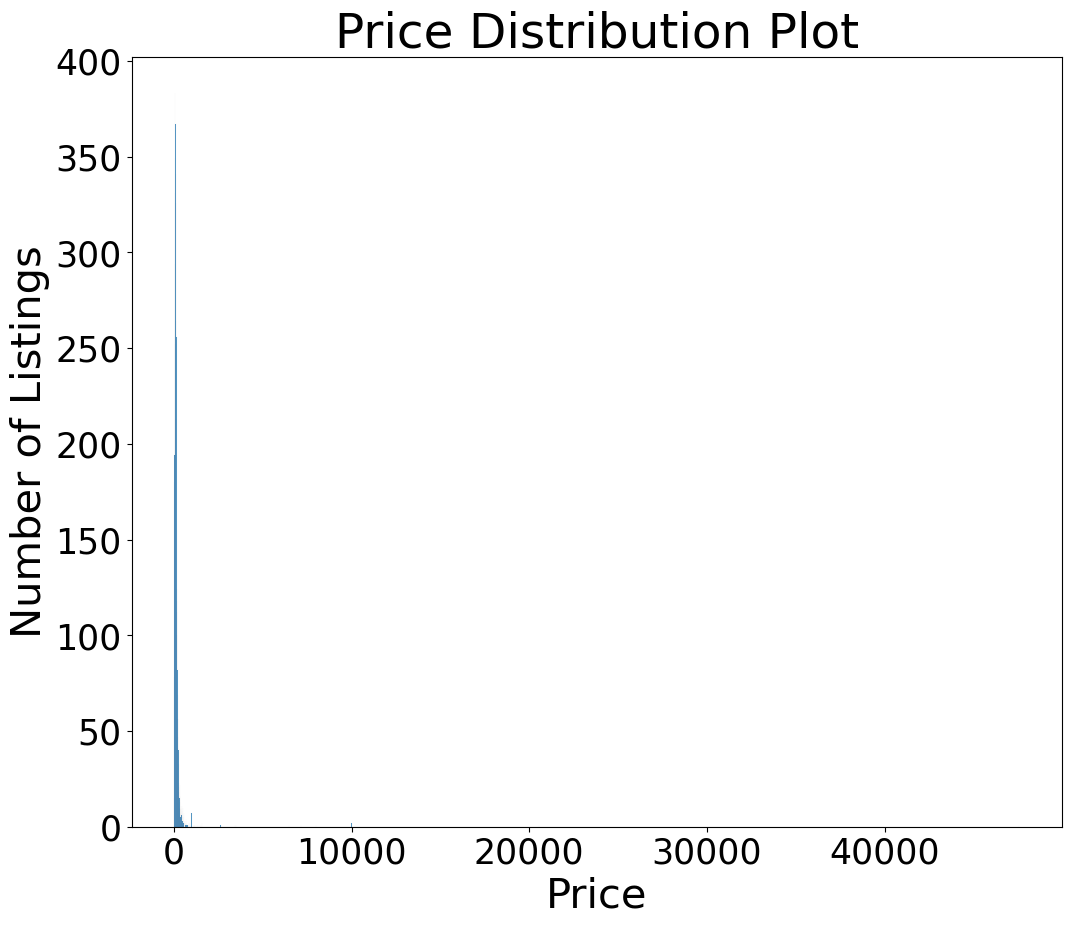

In [1347]:
plt.figure(figsize=(12,10))
sns.histplot(quality_df['price'])
plt.title("Price Distribution Plot",size=35)
plt.xlabel("Price",size=30)
plt.ylabel("Number of Listings",size=30)
# Customize the x ticks
plt.xticks(fontsize=25)
# Customize the y ticks
plt.yticks(fontsize=25)

In [1348]:
# print max and min price 
print("Max price: ", quality_df['price'].max())
print("Min price: ", quality_df['price'].min())

Max price:  47566.0
Min price:  11.0


Log price distribution plot

Text(0.5, 1.0, 'Log-Price Distribution Plot')

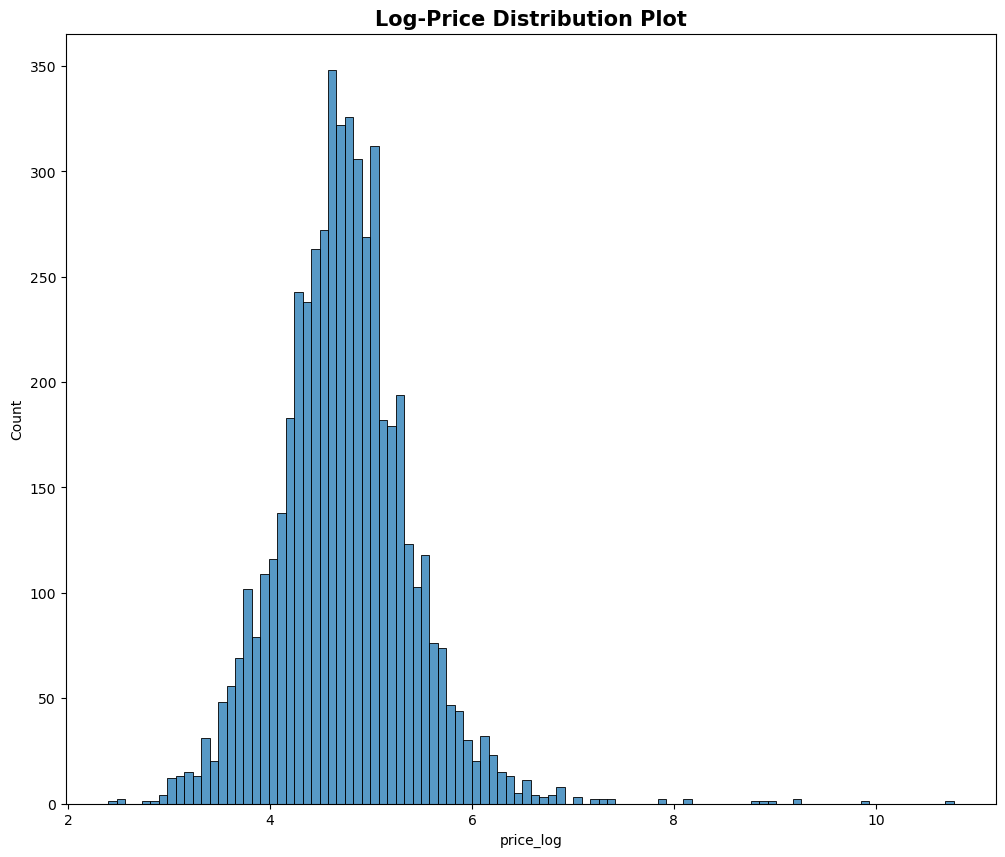

In [1349]:
quality_df['price_log'] = np.log(quality_df['price'])

plt.figure(figsize=(12,10))
sns.histplot(quality_df['price_log'])
plt.title("Log-Price Distribution Plot",size=15, weight='bold')

Using Z-Score to remove outliers for price column

In [1350]:
print("Original Shape:", quality_df.shape)
z_scores = np.abs(stats.zscore(quality_df['price']))

# Define a threshold for outlier removal (e.g., Z-score > 3)
threshold = 0.5

# Filter the dataframe to remove outliers
quality_df = quality_df[z_scores < threshold]

print("Filtered Shape:", quality_df.shape)

Original Shape: (5240, 101)
Filtered Shape: (5167, 101)


Text(0.5, 1.0, 'Price Distribution Plot')

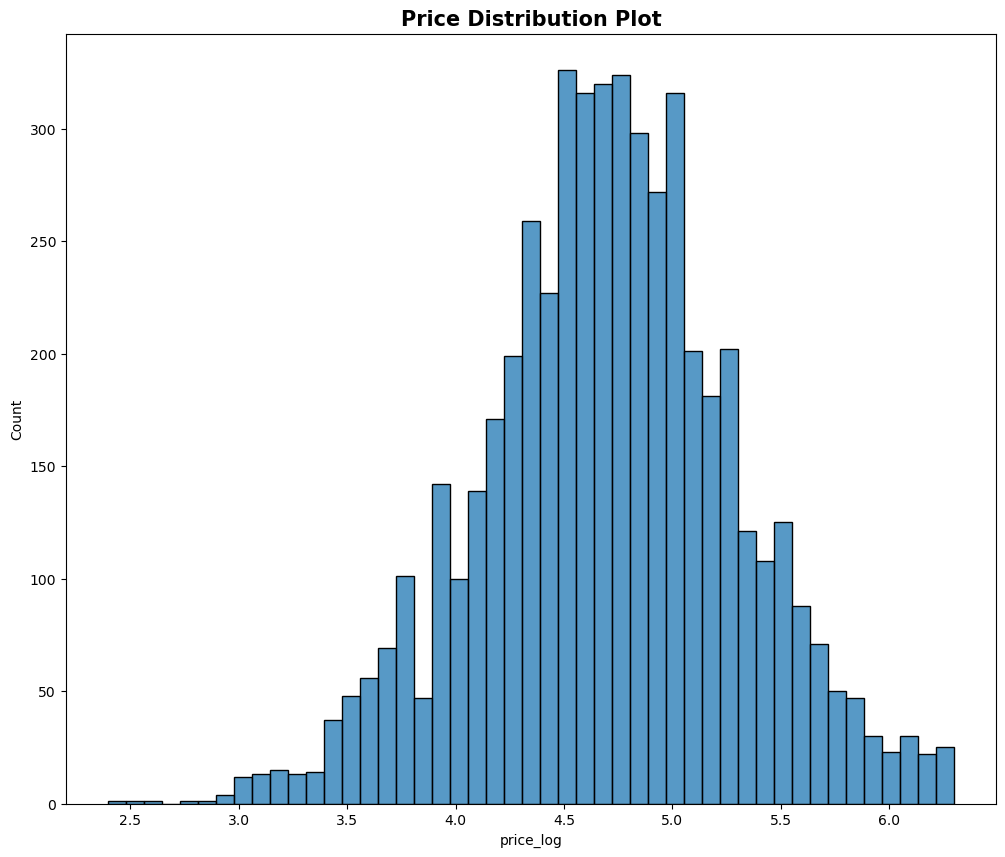

In [1351]:
plt.figure(figsize=(12,10))
sns.histplot(quality_df['price_log'])
plt.title("Price Distribution Plot",size=15, weight='bold')

Text(0.5, 1.0, 'Log-Price Distribution Plot')

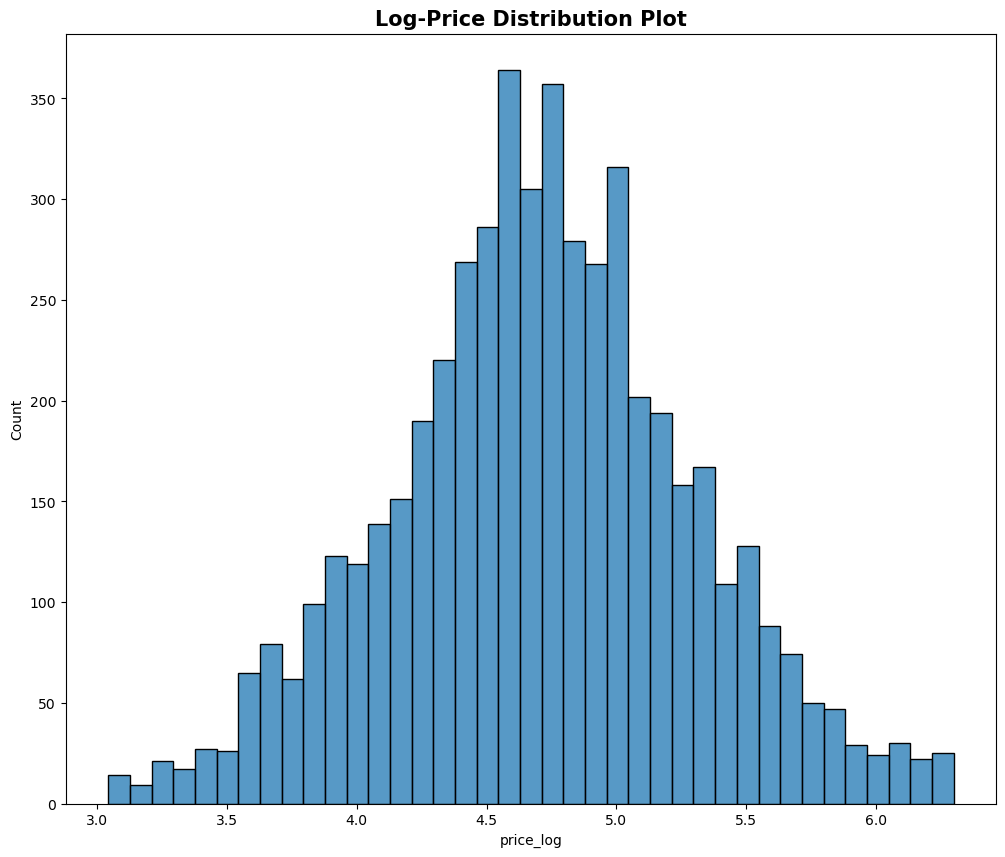

In [1352]:
quality_df = quality_df[(quality_df['price_log'] > 3)]
quality_df.dropna(inplace=True)
plt.figure(figsize=(12,10))
sns.histplot(quality_df['price_log'])
plt.title("Log-Price Distribution Plot",size=15, weight='bold')

/var/folders/g6/l9c_w0xj7zv_8_35j60mvnm80000gp/T/ipykernel_4346/845682084.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(quality_df['price_log'], kde=True, kde_kws={"color": "r"}, hist_kws={"edgecolor": "k", "linewidth": 1})


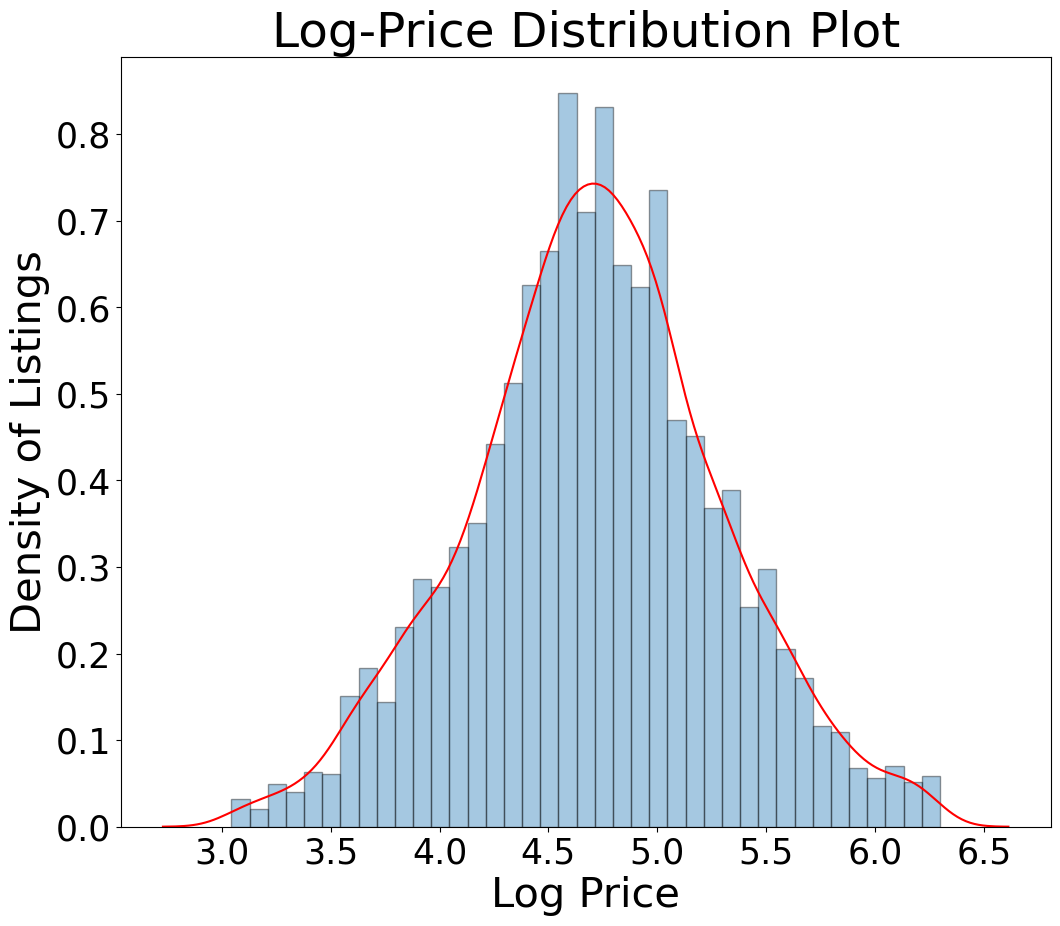

In [1353]:
quality_df = quality_df[(quality_df['price_log'] > 3)]
quality_df.dropna(inplace=True)
plt.figure(figsize=(12,10))
sns.distplot(quality_df['price_log'], kde=True, kde_kws={"color": "r"}, hist_kws={"edgecolor": "k", "linewidth": 1})
plt.title("Log-Price Distribution Plot",size=35)
plt.xlabel("Log Price",size=30)
plt.ylabel("Density of Listings",size=30)
# Customize the x ticks
plt.xticks(fontsize=25)
# Customize the y ticks
plt.yticks(fontsize=25)
plt.show()

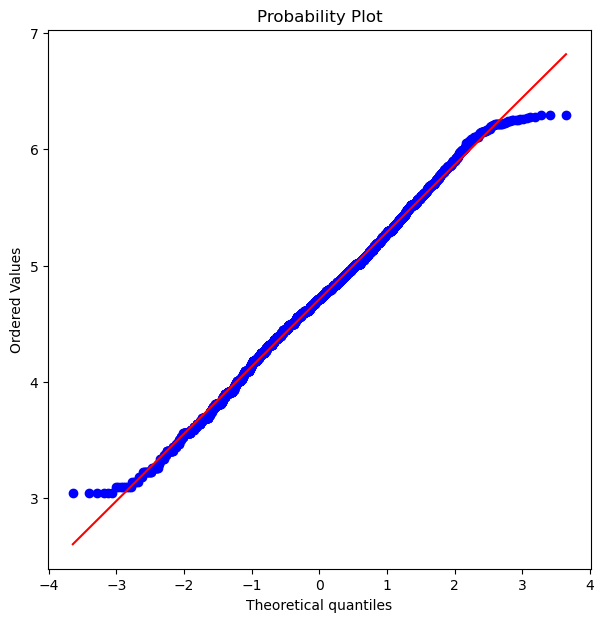

In [1354]:
plt.figure(figsize=(7,7))
stats.probplot(quality_df['price_log'], plot=plt)
plt.show()

In [1355]:
df_sorted = quality_df.sort_values('price', ascending=False)
df_sorted.head(20)
quality_df.dropna(inplace=True)


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0.5, 0, 'price_log'),
  Text(1.5, 0, 'accommodates'),
  Text(2.5, 0, 'bedrooms'),
  Text(3.5, 0, 'Room type: Entire Home'),
  Text(4.5, 0, 'beds'),
  Text(5.5, 0, 'bathrooms'),
  Text(6.5, 0, 'tv'),
  Text(7.5, 0, 'dishwasher'),
  Text(8.5, 0, 'crib'),
  Text(9.5, 0, 'kitchen')])

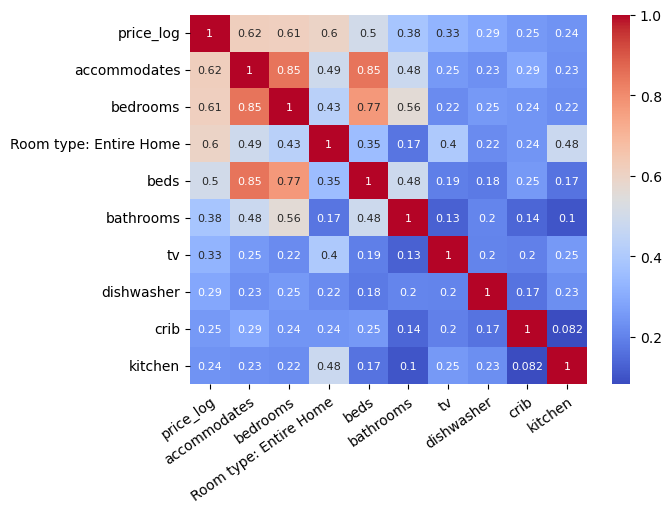

In [1356]:
# assume that data is a pandas DataFrame with 100 features and a target variable
# and the top 10 features are selected based on their correlation with the target variable
quality_df_without_price = quality_df.drop(columns=['price'])
top_10_features = quality_df_without_price.corr()['price_log'].sort_values(ascending=False)[:10].index.tolist()
data_subset = quality_df_without_price[top_10_features]

# compute the correlation matrix
corr_matrix = data_subset.corr()

# sort the correlation matrix by absolute values of correlation coefficients
corr_matrix_abs = np.abs(corr_matrix)
corr_matrix_sorted = corr_matrix_abs.sort_values(by=top_10_features, ascending=False)

# select the top 10 features
top_10_sorted = corr_matrix_sorted[top_10_features].iloc[:10]

# plot the heatmap
sns.heatmap(top_10_sorted, cmap='coolwarm', annot=True, annot_kws={"size": 8})

# tilt the x ticks
plt.xticks(rotation=35, ha='right', rotation_mode='anchor')

Models

Generic Linear Regression function

In [1357]:
def linear_reg(x, features_list):
    X_train, X_test, y_train, y_test = train_test_split(quality_df[features_list[0:x]], quality_df['price_log'], test_size=0.3, random_state=42)

    # Create a linear regression model
    model = LinearRegression()

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Predict on the test data
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    # Calculate coefficient of determination (R-squared)
    r2 = r2_score(y_test, y_pred)

    return r2

Random Forest 

In [1358]:
# drop the price column from the DataFrame
X = quality_df.drop(['price', 'price_log'], axis=1)

# select all other columns in the DataFrame as features
features = list(X.columns)

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X[features], quality_df['price_log'], test_size=0.25, random_state=42)

# create a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# fit the model to the training data
rf.fit(X_train, y_train)

# get the feature importances as a list
importances = list(rf.feature_importances_)

# zip the feature names and their corresponding importances
feature_importances = list(zip(features, importances))

# sort the features by importance in descending order
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

rForest_features_list = [x[0] for x in feature_importances]
# rForest_features_list.remove('price_log')

# for feature, importance in feature_importances:
#     print(f'{feature}: {importance}')

y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Calculate coefficient of determination (R-squared)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)


Mean Squared Error: 0.10754311113182966
Root Mean Squared Error: 0.3279376634847386
R-squared: 0.7081383820193488


Generic Random Forest Function for plotting graph

In [1359]:
def rf_reg(x, features_list):
    # X = quality_df.drop(['price', 'price_log'], axis=1)

    # # select all other columns in the DataFrame as features
    # features = list(X.columns)

    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(quality_df[features_list[0:x]], quality_df['price_log'], test_size=0.25, random_state=42)

    # create a Random Forest model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)

    # fit the model to the training data
    rf.fit(X_train, y_train)

    # Predict on the test data
    y_pred = rf.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    # Calculate coefficient of determination (R-squared)
    r2 = r2_score(y_test, y_pred)

    return r2


Feature Plotting for Random Forest


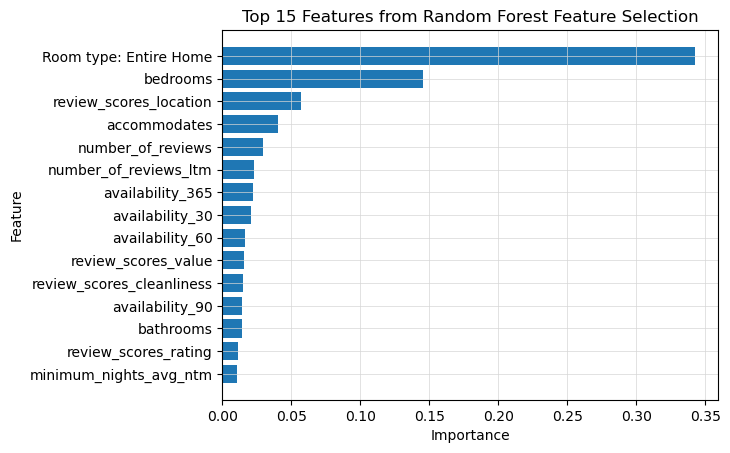

In [1360]:
# Get the first 14 features from rForest_features_list
features = rForest_features_list[:15]

# Get the corresponding importances for the first 14 features
importances = [x[1] for x in feature_importances[:15]]

# Reverse the order of the lists
features.reverse()
importances.reverse()

# Create a horizontal bar graph
plt.barh(features, importances)

# Add labels for the x and y axes and a title for the graph
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 15 Features from Random Forest Feature Selection')

# Add grid
plt.grid(color='#D6D6D6', linewidth=0.5)

# Display the graph
plt.show()



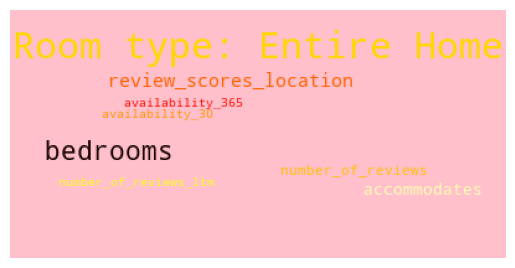

In [1361]:
# Get the top 20 features from rForest_features_list
features = rForest_features_list[:30]

# Create a dictionary of the features and their importances
feature_dict = dict(feature_importances[:30])

# Create a WordCloud object
wordcloud = WordCloud(colormap = 'hot',                   # font colors from palette
                background_color ='pink', min_font_size = 10, max_font_size=40)

# Generate the wordcloud
wordcloud.generate_from_frequencies(feature_dict)

# Create a figure and axes objects
fig, ax = plt.subplots()

# Add the wordcloud to the axes
ax.imshow(wordcloud)

# Set the title of the plot
# ax.set_title('Top 20 Features from Random Forest', size=18)

# Turn off the axis labels
ax.axis('off')

# Display the plot
plt.show()

Gradient-Boosting Feature Selection

['accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'Parking', 'Room Type: Hotel Room', 'Room Type: Private Room', 'Room Type: Shared Room', 'Room type: Entire Home', 'host_response_time_num', 'backyard', 'baking sheet', 'balcony', 'bathtub', 'bed linens', 'boo

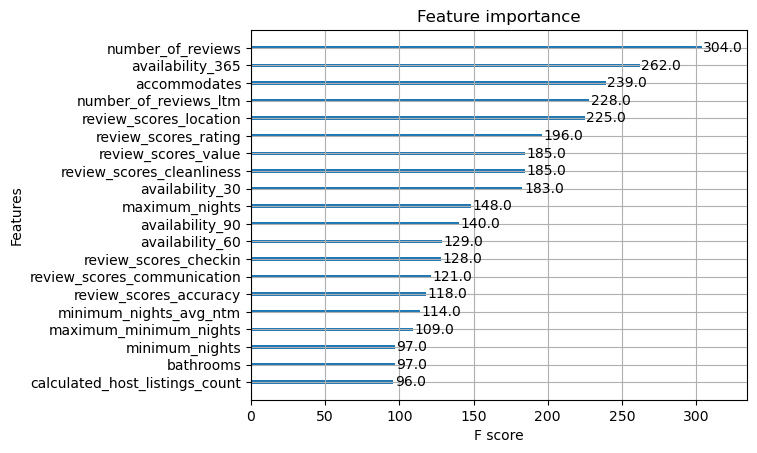

In [1362]:
# drop the price column from the DataFrame
X = quality_df.drop(['price', 'price_log'], axis=1)

# select all other columns in the DataFrame as features
features = list(X.columns)

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X[features], quality_df['price_log'], test_size=0.25, random_state=42)

# create an XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# fit the model to the training data
xgb_model.fit(X_train, y_train)

# plot the feature importances
plot_importance(xgb_model, max_num_features=20)

# get the selected features
XGBoost_features = xgb_model.get_booster().feature_names
print(XGBoost_features)

# get the feature importances
importances = xgb_model.feature_importances_

# create a list of tuples with feature names and importance values
feature_importances = list(zip(XGBoost_features, importances))

# sort the feature importances by importance values
sorted_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
sorted_importances_list = [x[0] for x in sorted_importances]

# # print the sorted feature importances
# for feature, importance in sorted_importances:
#     print(f"{feature}: {importance:.4f}")
# Predict on the test data
y_pred = xgb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Calculate coefficient of determination (R-squared)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)



Generic XGBoost Function to help in plotting

In [1363]:
def XGBoost_reg(x, features_list):
    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(quality_df[features_list[0:x]], quality_df['price_log'], test_size=0.25, random_state=42)

    # create an XGBoost model
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

    # fit the model to the training data
    xgb_model.fit(X_train, y_train)

    # Predict on the test data
    y_pred = xgb_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    # Calculate coefficient of determination (R-squared)
    r2 = r2_score(y_test, y_pred)

    return r2


Features vs accuracy for both models

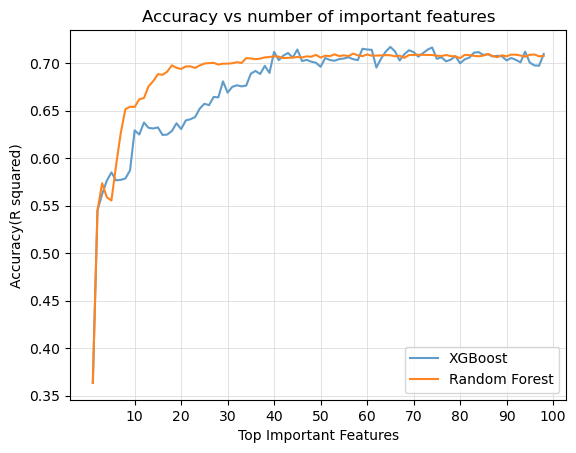

In [1364]:
# Plot the XGBoost graph in blue
xgb_x_values = list(range(1,len(sorted_importances_list)))
xgb_y_values = [XGBoost_reg(x, sorted_importances_list) for x in xgb_x_values]
plt.plot(xgb_x_values, xgb_y_values, color='#609CC9', label='XGBoost')

# Plot the random forest graph in red
rforest_x_values = list(range(1,len(rForest_features_list)))
rforest_y_values = [rf_reg(x, rForest_features_list) for x in rforest_x_values]
plt.plot(rforest_x_values, rforest_y_values, color='#FF841F', label='Random Forest')

# Add labels for the x and y axes and a title for the graph
plt.xticks([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.xlabel('Top Important Features')
plt.ylabel('Accuracy(R squared)')
plt.title('Accuracy vs number of important features')

# Add a legend to the graph
plt.legend()

# Add grid
plt.grid(color='#D6D6D6', linewidth=0.5)

# Display the graph
plt.show()

Question - 2

In [1365]:
listings_filepath = '/Users/abhayrakeshdeshmukhmaurya/Library/CloudStorage/OneDrive-UniversityofEdinburgh/CS/University/Year 2/Data Science/CW3/AirBnb/datasets/listings.csv'
listings_df = pd.read_csv(listings_filepath)

Data Cleaning

In [1366]:
columns = ['host_url', 'host_name', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'calendar_updated', 'calendar_last_scraped', 'picture_url', 
           'neighbourhood_group_cleansed', 'license', 'host_location', 'first_review', 'last_review', 'host_thumbnail_url', 
           'host_picture_url', 'description', 'neighborhood_overview', 'host_since', 'host_about', 'host_neighbourhood', 'host_verifications', 'neighbourhood',
           'reviews_per_month', 'bathrooms', 'bathrooms_text',  'host_response_time', 'property_type', 'id',
           'host_id', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
           'host_total_listings_count', 'host_has_profile_pic', 'host_identity_verified', 'bedrooms', 'beds', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', "calculated_host_listings_count_shared_rooms"]
listings_df.drop(columns=columns, inplace=True)

# Converting columns with (True, False) to (1, 0)
replace_dict = {'instant_bookable': {'t': 1, 'f': 0},
                'has_availability': {'t': 1, 'f': 0}
                }
listings_df = listings_df.replace(replace_dict)

# Creating parking column and assigning the rows with parking feature
parking_rows = listings_df[(listings_df['name'].str.contains('parking', case=False)) |
                           (listings_df['amenities'].apply(lambda x: 'parking' in x))]

listings_df['Parking'] = 0
listings_df.loc[parking_rows.index, 'Parking'] = 1

# Creating room_type_num column to store unique types in room_type
room_type_labels, room_type_unique = pd.factorize(listings_df['room_type'])
listings_df['room_type_num'] = room_type_labels

# Removing dollar sign from price
listings_df['price'] = listings_df['price'].str.replace(
    ',', '', regex=True).str.replace('$', '', regex=True).astype('float')

# drop further columns
columns = ['name', 'amenities', 'room_type_num']
listings_df.drop(columns=columns, inplace=True)

# Droping NaN
listings_df.dropna(axis=0, inplace=True)

# Resetting index to have sequential index

listings_df = listings_df.reset_index().sort_values(by='index')
listings_df = listings_df.drop(columns=['index'])
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6711 entries, 0 to 6710
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   neighbourhood_cleansed       6711 non-null   object 
 1   latitude                     6711 non-null   float64
 2   longitude                    6711 non-null   float64
 3   room_type                    6711 non-null   object 
 4   accommodates                 6711 non-null   int64  
 5   price                        6711 non-null   float64
 6   minimum_nights               6711 non-null   int64  
 7   maximum_nights               6711 non-null   int64  
 8   minimum_minimum_nights       6711 non-null   int64  
 9   maximum_minimum_nights       6711 non-null   int64  
 10  minimum_maximum_nights       6711 non-null   int64  
 11  maximum_maximum_nights       6711 non-null   int64  
 12  minimum_nights_avg_ntm       6711 non-null   float64
 13  maximum_nights_avg

In [1367]:
print("Original Shape:", listings_df.shape)
z_scores = np.abs(stats.zscore(listings_df['price']))

# Define a threshold for outlier removal (e.g., Z-score > 3)
threshold = 0.8

# Filter the dataframe to remove outliers
listings_df = listings_df[z_scores < threshold]

# Print the shape of the filtered dataframe

print("Filtered Shape:",   listings_df.shape)

Original Shape: (6711, 31)
Filtered Shape: (6617, 31)


<Axes: >

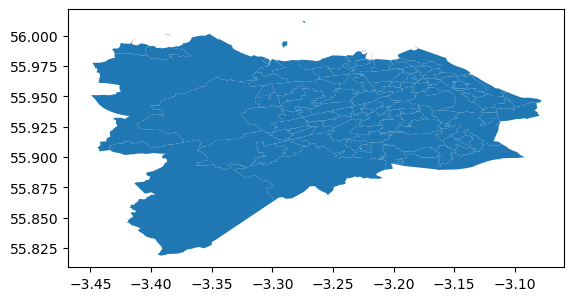

In [1368]:
import pandas as pd
import geopandas as gpd

# Read the CSV file into a pandas dataframe
# neighbourhoods_df = pd.read_csv('/Users/arneshsaha/Desktop/AirBnb/datasets/neighbourhoods.csv')
neighbourhoods_df = pd.read_csv('/Users/abhayrakeshdeshmukhmaurya/Library/CloudStorage/OneDrive-UniversityofEdinburgh/CS/University/Year 2/Data Science/CW3/AirBnb/datasets/neighbourhoods.csv')

# Create a geopandas dataframe with the geometry column
geometry = gpd.GeoSeries.from_wkt(neighbourhoods_df['geometry'])
neighbourhoods_gdf = gpd.GeoDataFrame(neighbourhoods_df, geometry=geometry)

# Plot the neighbourhoods
neighbourhoods_gdf.plot()

In [1369]:
# Create a geopandas dataframe with the latitude and longitude columns
geometry = gpd.points_from_xy(listings_df.longitude, listings_df.latitude)
gdf = gpd.GeoDataFrame(listings_df, geometry=geometry)
# gdf

# Read the neighbourhoods data from a CSV file into a pandas dataframe
neighbourhoods_df = pd.read_csv('/Users/abhayrakeshdeshmukhmaurya/Library/CloudStorage/OneDrive-UniversityofEdinburgh/CS/University/Year 2/Data Science/CW3/AirBnb/datasets/neighbourhoods.csv')
neighbourhoods_df.drop(columns=['neighbourhood_group'], inplace=True)
# Convert the geometry column to a GeoSeries object
geometry2 = gpd.GeoSeries.from_wkt(neighbourhoods_df['geometry'])

# Create a geopandas dataframe with the geometry column
neighbourhoods_gdf = gpd.GeoDataFrame(neighbourhoods_df, geometry=geometry2)
neighbourhoods_gdf

# Perform a spatial join to get the neighbourhoods for each Airbnb listing
merged = gpd.sjoin(gdf, neighbourhoods_gdf, op='within')
merged

# Calculate the average price for each neighbourhood
neighbourhood_prices = merged.groupby('neighbourhood')['price'].mean()
neighbourhood_availability_30 = merged.groupby('neighbourhood')['availability_30'].mean() 
neighbourhood_availability_365 = merged.groupby('neighbourhood')['availability_365'].mean()
neighborhood_counts = listings_df['neighbourhood_cleansed'].value_counts()
neighborhood_df = pd.DataFrame({'neighbourhood': neighborhood_counts.index, 'property_count': neighborhood_counts.values})



# Merge the average prices with the neighbourhoods geodataframe
merged_neighbourhoods = neighbourhoods_gdf.merge(neighbourhood_prices, on='neighbourhood')
merged_neighbourhoods = merged_neighbourhoods.merge(neighbourhood_availability_30, on='neighbourhood')
merged_neighbourhoods = merged_neighbourhoods.merge(neighbourhood_availability_365, on='neighbourhood')
merged_neighbourhoods = pd.merge(merged_neighbourhoods, neighborhood_df, on='neighbourhood', how='left')
merged_neighbourhoods = merged_neighbourhoods.drop(merged_neighbourhoods.columns[0], axis=1)


merged_neighbourhoods


# # Plot the average prices for each neighbourhood
# fig, ax = plt.subplots(1,figsize=(10, 6))

# merged_neighbourhoods.plot(column='availability_365', ax=ax, legend=True, cmap='OrRd', edgecolor='black', linewidth=0.5, aspect = 1.5)

# ax.set_title('Average Airbnb availability_365 by Neighbourhood in Edinburgh', fontdict={'fontsize': 16})
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')

# plt.show()


/Users/abhayrakeshdeshmukhmaurya/opt/anaconda3/envs/FDS/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,neighbourhood,geometry,price,availability_30,availability_365,property_count
0,Balerno and Bonnington Village,"MULTIPOLYGON (((-3.35805 55.91088, -3.35950 55...",109.571429,9.857143,202.071429,14
1,Currie West,"MULTIPOLYGON (((-3.30557 55.92039, -3.30418 55...",58.125000,9.125000,183.750000,8
2,Currie East,"MULTIPOLYGON (((-3.30808 55.89430, -3.30870 55...",85.000000,12.714286,166.000000,7
3,Baberton and Juniper Green,"MULTIPOLYGON (((-3.28635 55.91564, -3.28617 55...",77.714286,4.857143,101.142857,7
4,Bonaly and The Pentlands,"MULTIPOLYGON (((-3.30808 55.89430, -3.30834 55...",92.058824,7.764706,143.941176,17
...,...,...,...,...,...,...
106,South Gyle,"MULTIPOLYGON (((-3.30084 55.94246, -3.30081 55...",107.125000,7.187500,72.437500,16
107,"Ratho, Ingliston and Gogar","MULTIPOLYGON (((-3.34287 55.96432, -3.34150 55...",135.514286,11.828571,131.428571,35
108,Queensferry West,"MULTIPOLYGON (((-3.41600 55.99385, -3.41582 55...",102.888889,4.555556,89.777778,9
109,"Dalmeny, Kirkliston and Newbridge","MULTIPOLYGON (((-3.29012 55.99545, -3.28998 55...",133.736842,10.894737,165.315789,19


average prices for each neighbourhood

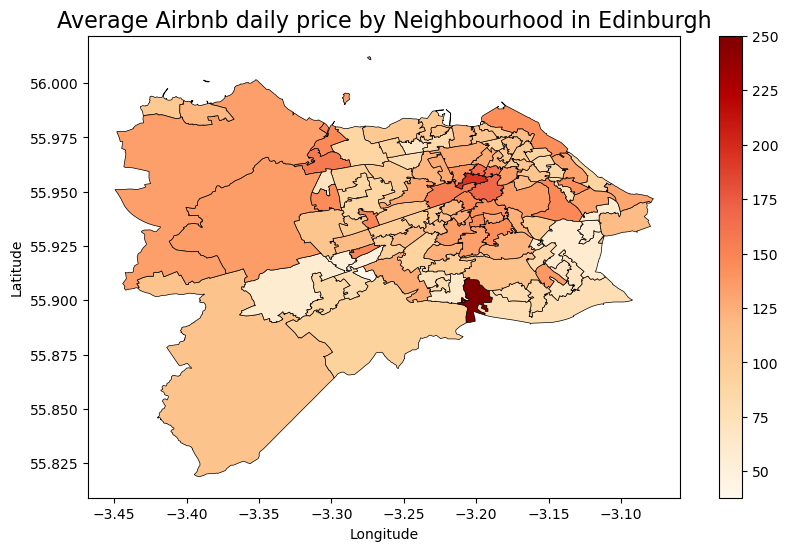

In [1370]:
# Plot the average prices for each neighbourhood
fig, ax = plt.subplots(1,figsize=(10, 6))

merged_neighbourhoods.plot(column='price', ax=ax, legend=True, cmap='OrRd', edgecolor='black', linewidth=0.5, aspect = 1.5)

ax.set_title('Average Airbnb daily price by Neighbourhood in Edinburgh', fontdict={'fontsize': 16})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()


average availability_30 for each neighbourhood

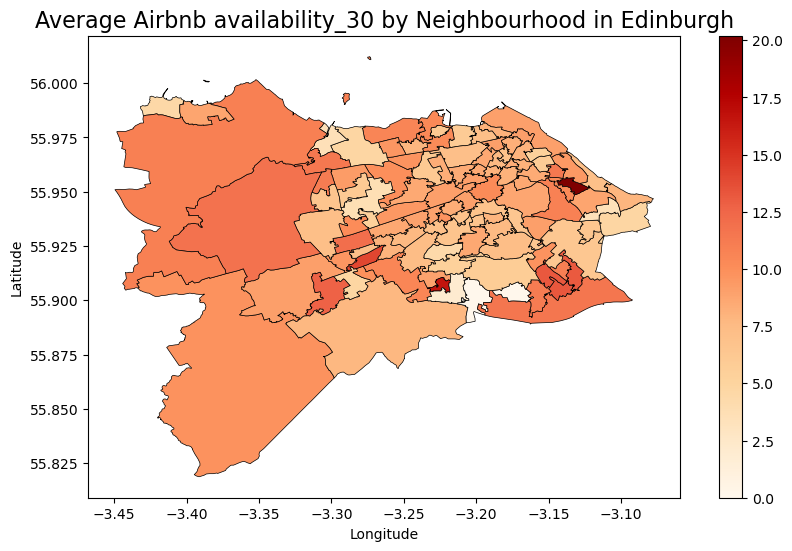

In [1371]:
# Plot the average prices for each neighbourhood
fig, ax = plt.subplots(1,figsize=(10, 6))

merged_neighbourhoods.plot(column='availability_30', ax=ax, legend=True, cmap='OrRd', edgecolor='black', linewidth=0.5, aspect = 1.5)

ax.set_title('Average Airbnb availability_30 by Neighbourhood in Edinburgh', fontdict={'fontsize': 16})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()


average availability_365 for each neighbourhood

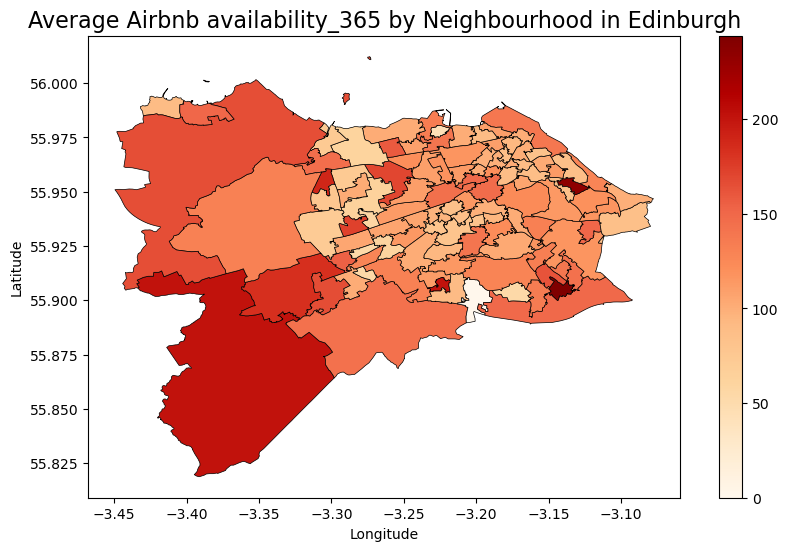

In [1372]:
# Plot the average prices for each neighbourhood
fig, ax = plt.subplots(1,figsize=(10, 6))

merged_neighbourhoods.plot(column='availability_365', ax=ax, legend=True, cmap='OrRd', edgecolor='black', linewidth=0.5, aspect = 1.5)

ax.set_title('Average Airbnb availability_365 by Neighbourhood in Edinburgh', fontdict={'fontsize': 16})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()


Number of listings in each neighbourhood

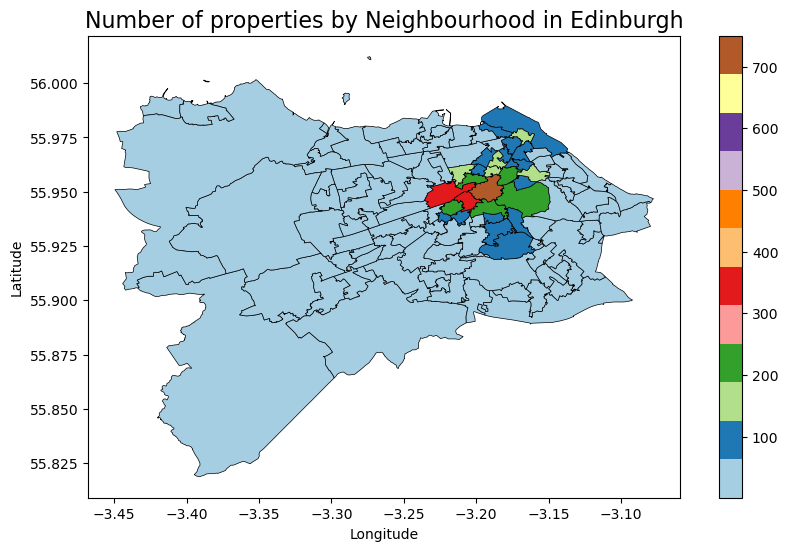

In [1373]:
# Plot the average prices for each neighbourhood
fig, ax = plt.subplots(1,figsize=(10, 6))

# Using the YlGnBu colormap
merged_neighbourhoods.plot(column='property_count', ax=ax, legend=True, cmap='Paired', edgecolor='black', linewidth=0.5, aspect=1.5)

ax.set_title('Number of properties by Neighbourhood in Edinburgh', fontdict={'fontsize': 16})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()


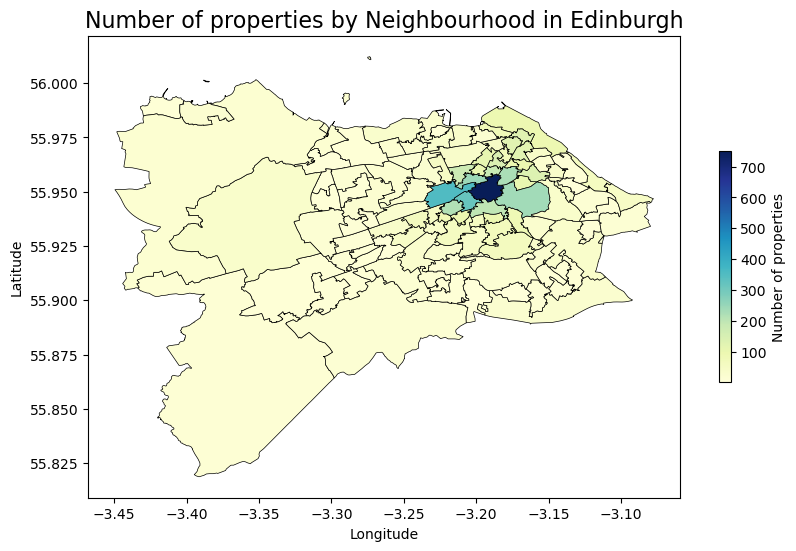

In [1374]:
# Plot the average prices for each neighbourhood
fig, ax = plt.subplots(1, figsize=(10, 6))

# Extract the minimum and maximum values of the property_count column
vmin = merged_neighbourhoods['property_count'].min()
vmax = merged_neighbourhoods['property_count'].max()

# Plot the data with the YlGnBu colormap and include the minimum and maximum values in the legend
merged_neighbourhoods.plot(column='property_count', ax=ax, legend=True, cmap='YlGnBu', edgecolor='black', linewidth=0.5, aspect=1.5, vmin=vmin, vmax=vmax, legend_kwds={'label': "Number of properties", 'orientation': "vertical", 'shrink': 0.5, 'pad': 0.05})

# Set the title and axis labels
ax.set_title('Number of properties by Neighbourhood in Edinburgh', fontdict={'fontsize': 16})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Get the colorbar object and set the font size of the labels
cbar = ax.get_figure().get_axes()[1]


plt.show()


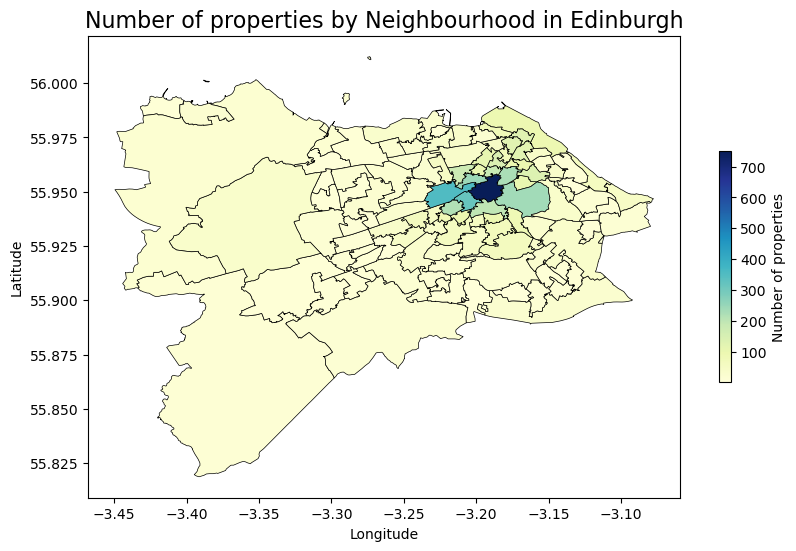

In [1375]:
# merged_neighbourhoods['price_per_person'] = merged_neighbourhoods[]

# Plot the average prices for each neighbourhood
fig, ax = plt.subplots(1, figsize=(10, 6))

# Extract the minimum and maximum values of the property_count column
vmin = merged_neighbourhoods['property_count'].min()
vmax = merged_neighbourhoods['property_count'].max()

# Plot the data with the YlGnBu colormap and include the minimum and maximum values in the legend
merged_neighbourhoods.plot(column='property_count', ax=ax, legend=True, cmap='YlGnBu', edgecolor='black', linewidth=0.5, aspect=1.5, vmin=vmin, vmax=vmax, legend_kwds={'label': "Number of properties", 'orientation': "vertical", 'shrink': 0.5, 'pad': 0.05})

# Set the title and axis labels
ax.set_title('Number of properties by Neighbourhood in Edinburgh', fontdict={'fontsize': 16})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Get the colorbar object and set the font size of the labels
cbar = ax.get_figure().get_axes()[1]


plt.show()

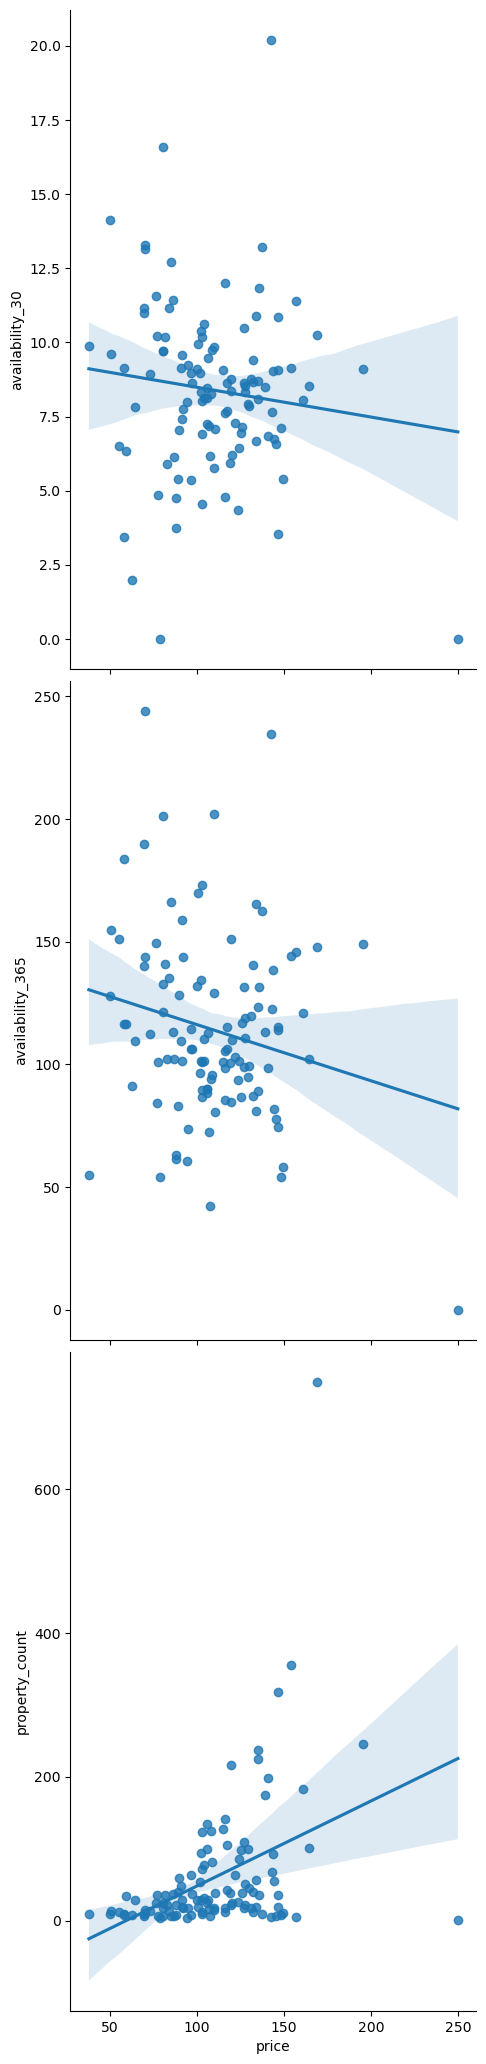

In [1376]:
sns.pairplot(merged_neighbourhoods, x_vars=['price'], y_vars=['availability_30', 'availability_365', 'property_count'], height=7, aspect=0.7, kind='reg')

Question - 3

In [1377]:
listings_filepath = '/Users/abhayrakeshdeshmukhmaurya/Library/CloudStorage/OneDrive-UniversityofEdinburgh/CS/University/Year 2/Data Science/CW3/AirBnb/datasets/listings.csv'
listings_df = pd.read_csv(listings_filepath)

In [1378]:
calendar_filepath = '/Users/abhayrakeshdeshmukhmaurya/Library/CloudStorage/OneDrive-UniversityofEdinburgh/CS/University/Year 2/Data Science/CW3/AirBnb/datasets/calendar.csv'
calendar_df = pd.read_csv(calendar_filepath)

In [1379]:
neighbourhoods_filepath = '/Users/abhayrakeshdeshmukhmaurya/Library/CloudStorage/OneDrive-UniversityofEdinburgh/CS/University/Year 2/Data Science/CW3/AirBnb/datasets/neighbourhoods.csv'
neighbourhoods_df = pd.read_csv(neighbourhoods_filepath)

In [1380]:
listings_for_calendar = listings_df.loc[:, ['id', 'neighbourhood_cleansed', 'latitude', 'longitude']]

In [1381]:
calendar_df['price'] = calendar_df['price'].str.replace(',', '',regex=True).str.replace('$', '',regex=True).astype('float')

In [1382]:
pivot_df = calendar_df.pivot(index='listing_id', columns='date', values='price')
pivot_df.to_csv('../datasets/pivot_df.csv')
pivot_df['2022-12-18']

# merge the two dataframes on the id and listing_id columns
merged_df = pd.merge(pivot_df, listings_for_calendar, left_on='listing_id', right_on='id')
merged_df

# specify the columns to exclude
cols_to_exclude = ['id', 'neighbourhood_cleansed', 'latitude', 'longitude']

# select all columns except the excluded ones
non_excluded_cols = [col for col in merged_df.columns if col not in cols_to_exclude]

# drop the rows where any column except the excluded ones has a value greater than 200
merged_df = merged_df[merged_df[non_excluded_cols].apply(lambda x: ~(x > 200).any(), axis=1)]

merged_df = merged_df.fillna(merged_df.median()) 
merged_df.dropna(inplace=True)

grouped_df = merged_df.groupby('neighbourhood_cleansed').mean().reset_index().rename(columns={'neighbourhood_cleansed': 'neighbourhood'})

grouped_df.drop(columns=['id', 'latitude', 'longitude'], inplace=True)

neighbourhoods_df.drop(columns=['neighbourhood_group'], inplace=True)
# Convert the geometry column to a GeoSeries object
geometry2 = gpd.GeoSeries.from_wkt(neighbourhoods_df['geometry'])
# Create a geopandas dataframe with the geometry column
neighbourhoods_gdf = gpd.GeoDataFrame(neighbourhoods_df, geometry=geometry2)
type(neighbourhoods_gdf.geometry)

grouped_df_nbd = neighbourhoods_gdf.merge(grouped_df, on='neighbourhood')
grouped_df_nbd.drop(grouped_df_nbd.columns[0], axis=1, inplace=True)
print(type(grouped_df_nbd.geometry))

/var/folders/g6/l9c_w0xj7zv_8_35j60mvnm80000gp/T/ipykernel_4346/774270692.py:18: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  merged_df = merged_df.fillna(merged_df.median())


<class 'geopandas.geoseries.GeoSeries'>


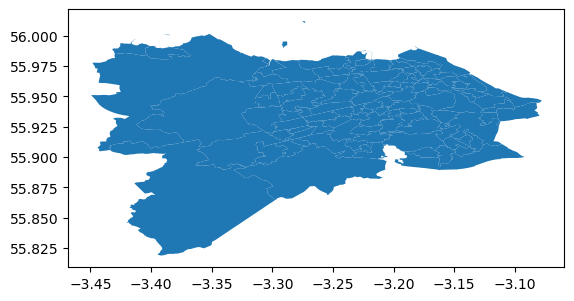

In [1383]:
grouped_df_nbd.plot()
grouped_df_nbd.to_csv('../datasets/grouped_df_nbd.csv')

Price Fluctuation based on neighbourhood

In [1384]:
# Trying to do a standard deviation column for each neighbourhood's mean price fluctuation
price_cols = [col for col in grouped_df_nbd.columns if col.startswith('20')]

# Calculate the standard deviation of the mean price across all dates for each neighbourhood
grouped_df_nbd['price_std'] = grouped_df_nbd[price_cols].std(axis=1)

# Sort the neighbourhoods by price fluctuation over the year
grouped_df_nbd.sort_values(by='price_std', ascending=False)

,neighbourhood,geometry,2022-12-16,2022-12-17,2022-12-18,2022-12-19,2022-12-20,2022-12-21,2022-12-22,2022-12-23,...,2023-12-08,2023-12-09,2023-12-10,2023-12-11,2023-12-12,2023-12-13,2023-12-14,2023-12-15,2023-12-16,price_std
97,"Barnton, Cammo and Cramond South","MULTIPOLYGON (((-3.30916 55.96957, -3.30915 55...",127.500000,138.750000,138.750000,138.750000,138.750000,138.750000,138.750000,138.750000,...,151.000000,151.000000,151.000000,151.250000,151.250000,151.250000,151.250000,151.000000,95.0,10.589115
20,Moredun and Craigour,"MULTIPOLYGON (((-3.13933 55.91860, -3.13862 55...",70.555556,70.555556,70.555556,68.333333,68.333333,69.111111,69.111111,62.222222,...,75.555556,75.666667,75.000000,76.000000,76.000000,76.000000,76.000000,76.111111,95.0,8.737128
19,Greenbank and The Braids,"MULTIPOLYGON (((-3.21008 55.91993, -3.21025 55...",87.166667,87.166667,85.833333,85.833333,85.833333,85.833333,85.833333,87.166667,...,74.500000,74.500000,73.166667,73.166667,73.166667,73.166667,73.166667,74.500000,95.0,6.776605
87,Blackhall,"MULTIPOLYGON (((-3.26070 55.96441, -3.24975 55...",79.466667,81.800000,73.200000,70.533333,70.533333,70.533333,71.466667,79.133333,...,74.533333,74.533333,68.200000,68.200000,68.200000,68.200000,68.200000,74.533333,95.0,6.416602
99,East Craigs North,"MULTIPOLYGON (((-3.30048 55.95916, -3.29900 55...",88.666667,88.500000,81.833333,81.000000,80.666667,81.833333,88.500000,90.500000,...,87.166667,87.333333,81.000000,80.500000,80.500000,80.333333,80.500000,87.166667,95.0,6.148932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,Restalrig (Loganlea) and Craigentinny West,"MULTIPOLYGON (((-3.14581 55.96305, -3.14562 55...",78.548387,79.290323,78.064516,78.548387,79.161290,79.161290,78.935484,83.935484,...,80.870968,80.903226,80.419355,80.354839,80.354839,80.354839,80.387097,80.870968,95.0,1.743217
49,Willowbrae and Duddingston Village,"MULTIPOLYGON (((-3.14938 55.95536, -3.14916 55...",76.045455,76.045455,75.818182,75.681818,76.045455,76.772727,77.909091,79.681818,...,78.863636,78.863636,77.500000,77.272727,77.272727,77.272727,77.318182,78.863636,95.0,1.684999
91,Granton South and Wardieburn,"MULTIPOLYGON (((-3.22401 55.98043, -3.22225 55...",67.000000,67.000000,67.000000,67.000000,67.000000,69.500000,69.500000,69.500000,...,69.500000,69.750000,69.750000,69.500000,69.500000,69.500000,69.500000,69.500000,95.0,1.367453
26,Mortonhall and Anwickhill,"MULTIPOLYGON (((-3.17067 55.90843, -3.17037 55...",80.000000,80.000000,78.333333,78.333333,78.333333,78.333333,78.333333,80.000000,...,80.000000,80.000000,78.333333,78.333333,78.333333,78.333333,78.333333,80.000000,95.0,1.133636


<Axes: >

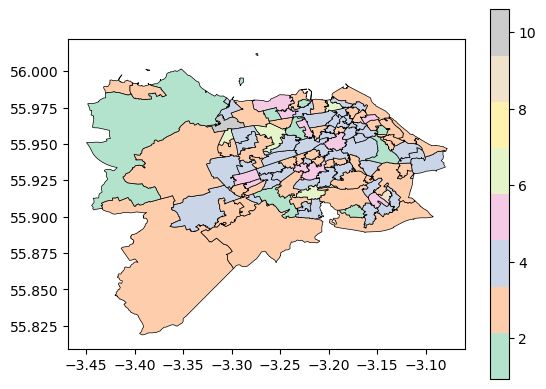

In [1385]:
grouped_df_nbd.plot(column='price_std', legend=True, cmap='Pastel2', edgecolor='black', linewidth=0.5, aspect = 1.5)

In [1386]:
grouped_df_nbd_sorted = grouped_df_nbd.sort_values(by='price_std', ascending=False).reset_index(drop=True)

# Extract month and year from column names
date_columns = [col for col in grouped_df_nbd_sorted.columns if col not in ['neighbourhood', 'geometry', 'price_std']]
# The dates are in the format 'YYYY-MM-DD'. We want to extract the month and year from the date
month = [col[5:7] for col in date_columns]


In [1387]:
# Create a list of unique neighborhoods
unique_neighborhoods = grouped_df_nbd_sorted['neighbourhood'].unique()

# Create an empty DataFrame with neighborhoods as index and months as columns
grouped_nbd_monthly_price = pd.DataFrame(index=unique_neighborhoods, columns=[str(m) for m in range(1, 13)])

# Initialize a dictionary to store the prices for December 2022 and December 2023 separately
december_prices = {n: {'sum': 0, 'count': 0} for n in unique_neighborhoods}

# Iterate over the neighborhoods
for _, row in grouped_df_nbd_sorted.iterrows():
    neighborhood = row['neighbourhood']

    # Initialize variables for monthly calculations
    current_month = int(month[0])
    current_sum = row[date_columns[0]]
    current_count = 1

    # Iterate over the month list and calculate the mean monthly price
    for i, m in enumerate(month[1:], start=1):
        m = int(m)  # Convert month to integer
        if m == current_month:
            current_sum += row[date_columns[i]]
            current_count += 1
        else:
            if current_month == 12:
                # Save the prices for December separately
                december_prices[neighborhood]['sum'] += current_sum
                december_prices[neighborhood]['count'] += current_count
            else:
                mean_monthly_price_value = current_sum / current_count
                grouped_nbd_monthly_price.at[neighborhood, str(current_month)] = mean_monthly_price_value

            current_month = m
            current_sum = row[date_columns[i]]
            current_count = 1

    if current_month == 12:
        # Save the prices for December separately
        december_prices[neighborhood]['sum'] += current_sum
        december_prices[neighborhood]['count'] += current_count
    else:
        mean_monthly_price_value = current_sum / current_count
        grouped_nbd_monthly_price.at[neighborhood, str(current_month)] = mean_monthly_price_value

# Calculate the combined mean monthly price for December
for neighborhood in unique_neighborhoods:
    grouped_nbd_monthly_price.at[neighborhood, '12'] = december_prices[neighborhood]['sum'] / december_prices[neighborhood]['count']

# If you want to convert it back to a GeoDataFrame
grouped_nbd_monthly_price.reset_index(inplace=True)
grouped_nbd_monthly_price.rename(columns={'index': 'neighbourhood'}, inplace=True)
grouped_nbd_monthly_price = gpd.GeoDataFrame(grouped_nbd_monthly_price)


In [1388]:
grouped_nbd_monthly_price = neighbourhoods_gdf.merge(grouped_nbd_monthly_price, on='neighbourhood')
# Trying to do a standard deviation column for each neighbourhood's mean price fluctuation
price_cols = ['1', '2', '3', '4', '5', '6', '7', '8','9', '10', '11', '12']
# Calculate the standard deviation of the mean price across all dates for each neighbourhood
grouped_nbd_monthly_price['price_std'] = grouped_nbd_monthly_price[price_cols].std(axis=1)

grouped_nbd_monthly_price.sort_values(by='price_std', ascending=False)


,Unnamed: 0,neighbourhood,geometry,1,2,3,4,5,6,7,8,9,10,11,12,price_std
97,98,"Barnton, Cammo and Cramond South","MULTIPOLYGON (((-3.30916 55.96957, -3.30915 55...",131.935484,131.25,125.0,130.258333,134.370968,145.55,151.137097,151.153226,151.133333,151.145161,151.15,143.148438,10.135771
20,20,Moredun and Craigour,"MULTIPOLYGON (((-3.13933 55.91860, -3.13862 55...",60.874552,60.25,60.250896,65.859259,69.562724,73.877778,82.878136,84.695341,80.292593,76.222222,75.096296,73.065972,8.653856
19,19,Greenbank and The Braids,"MULTIPOLYGON (((-3.21008 55.91993, -3.21025 55...",73.973118,70.261905,76.112903,73.344444,75.016129,79.427778,84.026882,91.0,83.722222,76.155914,79.3,81.890625,5.759727
10,10,Parkhead and Sighthill,"MULTIPOLYGON (((-3.27006 55.92530, -3.26999 55...",61.168459,60.936508,60.939068,60.944444,60.921147,59.562963,60.734767,69.544803,70.207407,70.154122,70.162963,73.538194,5.242303
87,88,Blackhall,"MULTIPOLYGON (((-3.26070 55.96441, -3.24975 55...",70.333333,68.37619,69.234409,70.851111,71.636559,72.313333,72.176344,87.735484,71.2,70.329032,69.842222,75.816667,5.157108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,89,Drylaw,"MULTIPOLYGON (((-3.23642 55.96744, -3.23666 55...",60.722581,60.545238,60.643011,60.891111,61.445161,61.968889,61.903226,61.793548,62.042222,61.795699,61.822222,63.7,0.867756
94,95,Muirhouse,"MULTIPOLYGON (((-3.25355 55.97440, -3.25312 55...",62.702509,62.313492,62.734767,62.874074,63.261649,63.366667,63.40681,63.146953,63.153704,63.150538,63.148148,64.852431,0.615268
6,6,Colinton and Kingsknowe,"MULTIPOLYGON (((-3.25012 55.92184, -3.24984 55...",83.993088,83.571429,83.509217,83.811905,84.050691,84.288095,84.28341,84.776498,84.328571,84.246544,84.252381,84.589286,0.377474
26,27,Mortonhall and Anwickhill,"MULTIPOLYGON (((-3.17067 55.90843, -3.17037 55...",78.763441,78.809524,78.817204,78.833333,78.763441,78.833333,78.817204,78.763441,78.888889,78.763441,78.777778,79.427083,0.184338


<Axes: >

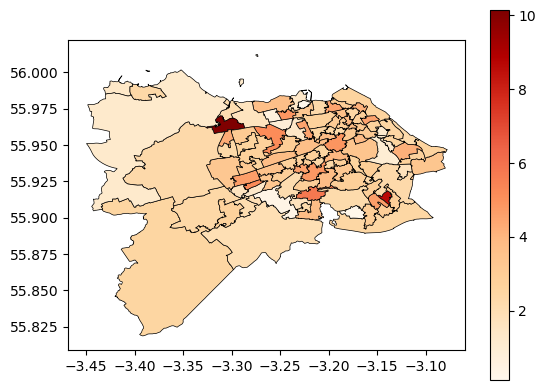

In [1389]:
grouped_nbd_monthly_price[grouped_nbd_monthly_price['price_std']> 4]

grouped_nbd_monthly_price.plot(column='price_std', legend=True, cmap='OrRd', edgecolor='black', linewidth=0.5, aspect = 1.5)

In [1390]:
# create bins
bins = [0, 2, 4, 6,11]

# create labels for bins
labels = ['0-2', '2-4', '4-6', '6-11']

# bin the data
grouped_nbd_monthly_price['price_range'] = pd.cut(grouped_nbd_monthly_price['price_std'], bins=bins, labels=labels)

# Group the data by 'price_category' and aggregate the values using mean
agg_functions = {'1': 'mean', '2': 'mean', '3': 'mean', '4': 'mean', '5': 'mean', 
                 '6': 'mean', '7': 'mean', '8': 'mean', '9': 'mean', '10': 'mean', 
                 '11': 'mean', '12': 'mean', 'price_std': 'mean'}
new_df = grouped_nbd_monthly_price.groupby('price_range').agg(agg_functions).reset_index()

# Drop the 'price_category' column if not needed
new_df = new_df.drop(columns=['price_range'])
new_df

,1,2,3,4,5,6,7,8,9,10,11,12,price_std
0,68.670469,68.225047,68.370078,68.524433,69.004549,69.430720,69.933931,70.509115,69.219697,69.066017,69.112752,71.108145,1.216003
1,83.296653,83.143064,83.620766,84.804733,85.612073,87.549789,88.526302,92.102877,87.707679,87.007437,87.004591,87.808216,2.884072
2,81.564468,81.220990,82.123817,82.811264,83.863758,86.108417,88.215172,96.492182,88.086796,86.346521,86.276547,88.634545,4.732743
3,96.405018,95.750000,92.625448,98.058796,101.966846,109.713889,117.007616,117.924283,115.712963,113.683692,113.123148,108.107205,9.394814


(array([ 60.,  70.,  80.,  90., 100., 110., 120., 130.]),
 [Text(0, 60.0, '60'),
  Text(0, 70.0, '70'),
  Text(0, 80.0, '80'),
  Text(0, 90.0, '90'),
  Text(0, 100.0, '100'),
  Text(0, 110.0, '110'),
  Text(0, 120.0, '120'),
  Text(0, 130.0, '130')])

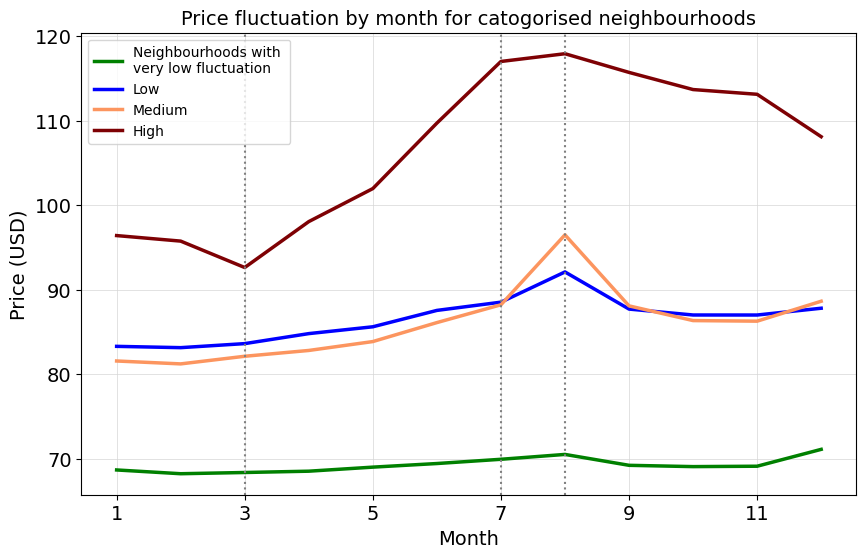

In [1391]:
new_df = new_df.drop(columns=['price_std'])
new_df_t = new_df.transpose()
fig, ax = plt.subplots()
# set the size of diagram
fig.set_size_inches(10, 6)

# ax = plt.figure(figsize=(20, 20))
colors = ['green', 'blue', "#FC955F", '#7E0104']

# Plot a line graph
new_df_t.plot(kind='line', color = colors, ax = ax, lw = 2.5)


# Set the x and y labels
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Price (USD)', fontsize=14)

ax.set_title('Price fluctuation by month for catogorised neighbourhoods', fontsize = 14)
# Add the legend
ax.legend(['Neighbourhoods with \nvery low fluctuation', 'Low', 'Medium', 'High'])
plt.grid(color='#D6D6D6', linewidth=0.5)

# add vertical dashed line at x=8
ax.axvline(x=7, linestyle=':', color='gray')
ax.axvline(x=6, linestyle=':', color='gray')
ax.axvline(x=2, linestyle=':', color='gray')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)   
